In [4]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

# 한글 폰트 설정 (Windows)
plt.rcParams['font.family'] = 'Malgun Gothic'

# 마이너스 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False


### 기준금리 EDA


📌 DF3 RAW HEAD


,통계표,계정항목,단위,변환,1999/05,1999/06,1999/07,1999/08,1999/09,1999/10,...,2025/03,2025/04,2025/05,2025/06,2025/07,2025/08,2025/09,2025/10,2025/11,2025/12
0,1.3.1. 한국은행 기준금리 및 여수신금리,한국은행 기준금리,연%,원자료,4.75,4.75,4.75,4.75,4.75,4.75,...,2.75,2.75,2.5,2.5,2.5,2.5,2.5,2.5,2.5,2.5



📌 DATE 변환 확인
NaT 개수: 0 / 320

📌 DF3 HEAD


계정항목,date,한국은행 기준금리
0,2004-01-01,3.75
1,2004-02-01,3.75
2,2004-03-01,3.75
3,2004-04-01,3.75
4,2004-05-01,3.75
5,2004-06-01,3.75
6,2004-07-01,3.75
7,2004-08-01,3.50
8,2004-09-01,3.50
9,2004-10-01,3.50



📌 DF3 SHAPE
(264, 2)

📌 DF3 DTYPES


,dtype
계정항목,
date,datetime64[ns]
한국은행 기준금리,float64



📌 MISSING VALUES


,missing_count
계정항목,
date,0
한국은행 기준금리,0



📌 DESCRIBE (원본 수치 컬럼)


계정항목,한국은행 기준금리
count,264.000000
mean,2.556818
std,1.198300
min,0.500000
25%,1.500000
50%,2.500000
75%,3.500000
max,5.250000



📌 BOXPLOT (원본 수치 컬럼만: Mean / Q1 / Q3)

📊 한국은행 기준금리
Mean: 2.557
Q1  : 1.500
Q3  : 3.500


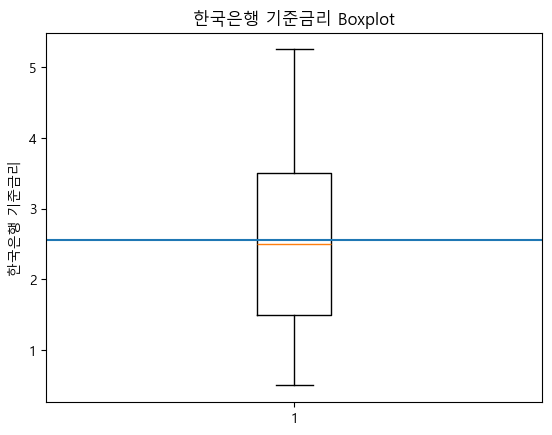

In [5]:
def section(title):
    print("\n" + "="*60)
    print(f"📌 {title}")
    print("="*60)

# ============================================================
# DF3: 기준금리(1999.5~).csv
# ✅ 행렬 변환(전치)
# ✅ 날짜: datetime (yyyy-mm-dd)  ※ 월 데이터 → 매월 1일로 저장
# ✅ 2004-01부터 사용
# ✅ YoY + YoY 기준 Z-score 파트는 "주석 처리"
# ✅ 박스플롯은 "원본 수치 컬럼"만 (yoy/z 제외)
# ============================================================

# 1) 로딩
df3_raw = pd.read_csv("data/기준금리(1999.5~).csv")
df3 = df3_raw.copy()

section("DF3 RAW HEAD")
display(df3.head())

# 2) 메타 컬럼 삭제 (통계표/단위/변환)
meta_cols = [c for c in df3.columns if any(k in str(c) for k in ["통계표", "단위", "변환"])]
df3 = df3.drop(columns=meta_cols, errors="ignore")

# 3) 첫 컬럼(항목)을 index로 설정
item_col = df3.columns[0]
df3 = df3.set_index(item_col)

# 4) 행렬 변환(전치)
df3_t = df3.T.reset_index().rename(columns={"index": "date_raw"})

# 5) 날짜 변환 (YYYY/MM -> datetime)
date_str = (
    df3_t["date_raw"].astype(str).str.strip()
    .str.replace(".", "/", regex=False)
    .str.replace("-", "/", regex=False)
)
df3_t["date"] = pd.to_datetime(date_str, format="%Y/%m", errors="coerce")  # YYYY-MM-01

section("DATE 변환 확인")
print("NaT 개수:", df3_t["date"].isna().sum(), "/", len(df3_t))

# 6) 2004-01 이후 필터
df3_t = df3_t[df3_t["date"] >= pd.Timestamp("2004-01-01")]

# 7) numeric 변환
value_cols = [c for c in df3_t.columns if c not in ["date_raw", "date"]]
for col in value_cols:
    df3_t[col] = (
        df3_t[col].astype(str)
        .str.replace(",", "", regex=False)
        .str.replace(" ", "", regex=False)
        .replace({"": np.nan, "-": np.nan, "nan": np.nan, "None": np.nan})
    )
    df3_t[col] = pd.to_numeric(df3_t[col], errors="coerce")

# 8) 최종 df3 정리 (date 첫 컬럼)
df3 = (
    df3_t.drop(columns=["date_raw"])
    .sort_values("date")
    .reset_index(drop=True)
)
df3 = df3[["date"] + [c for c in df3.columns if c != "date"]]

# ============================================================
# 9) YoY + YoY 기준 Z-score (주석 처리)
# ============================================================

# num_cols = df3.select_dtypes(include=np.number).columns.tolist()
#
# # YoY (2005-01부터 유효)
# for c in num_cols:
#     df3[f"{c}_yoy"] = df3[c].pct_change(12) * 100
#
# # YoY 기준 Z-score (2005-01~ 구간 기반)
# mask_2005 = df3["date"] >= pd.Timestamp("2005-01-01")
# for c in num_cols:
#     yc = f"{c}_yoy"
#     mu = df3.loc[mask_2005, yc].mean()
#     sigma = df3.loc[mask_2005, yc].std(ddof=0)
#     df3[f"{yc}_z"] = (df3[yc] - mu) / sigma

# ============================================================
# 10) 간단 EDA
# ============================================================
section("DF3 HEAD")
display(df3.head(15))

section("DF3 SHAPE")
print(df3.shape)

section("DF3 DTYPES")
display(pd.DataFrame(df3.dtypes, columns=["dtype"]))

section("MISSING VALUES")
display(pd.DataFrame(df3.isnull().sum(), columns=["missing_count"]).sort_values("missing_count", ascending=False))

# 원본 수치 컬럼만 describe/boxplot
num_cols = df3.select_dtypes(include=np.number).columns.tolist()

section("DESCRIBE (원본 수치 컬럼)")
display(df3[num_cols].describe())

# ============================================================
# 11) 박스플롯 + Mean/Q1/Q3 (원본 수치 컬럼만)
# ============================================================
section("BOXPLOT (원본 수치 컬럼만: Mean / Q1 / Q3)")

for col in num_cols:
    mean_val = df3[col].mean()
    Q1 = df3[col].quantile(0.25)
    Q3 = df3[col].quantile(0.75)

    print(f"\n📊 {col}")
    print(f"Mean: {mean_val:.3f}")
    print(f"Q1  : {Q1:.3f}")
    print(f"Q3  : {Q3:.3f}")

    plt.figure()
    plt.boxplot(df3[col].dropna())
    plt.axhline(mean_val)
    plt.title(f"{col} Boxplot")
    plt.ylabel(col)
    plt.show()


In [6]:
# ✅ CSV 저장
df3_to_save = df3.copy()
df3_to_save["date"] = df3_to_save["date"].astype(str)
df3_to_save.to_csv("data/기준금리_전처리완료.csv", index=False, encoding="utf-8-sig")